## Вывести с помощью seaborn график появления обновлений, линейную регрессию по нему и порассуждать о том, как эти данные соотносятся с предыдущим домашним заданием. 

In [37]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

Загружаем данные, которые мы сохранили предварительно. 
Параметр parse_dates необходим, когда ваши данные содержат даты - так как csv формат это по 
сути plain text формат, то и даты в нем просто строки текста и без перечня колонок с датами 
в этом параметре они будут загружены как текст.

In [38]:
df = pd.read_csv('tempostorm_date.csv', encoding='utf-8', parse_dates=['date'])
df.head()

,Unnamed: 0,date,createdDate,name,playerClass,index
0,0,2014-12-11 20:01:17.997,2014-12-11T20:01:17.997Z,Windfury Shaman by Reynad,Shaman,0
1,1,2014-12-11 20:13:16.995,2014-12-11T20:13:16.995Z,BMA's Chowlock Deck,Warlock,1
2,2,2014-12-12 03:56:04.037,2014-12-12T03:56:04.037Z,[GvG] Mecha Zoo By Gaara,Warlock,2
3,3,2014-12-12 22:57:19.684,2014-12-12T22:57:19.684Z,Tempo Mage,Mage,3
4,4,2014-12-12 23:50:56.608,2014-12-12T23:50:56.608Z,Kitkatz's Control Warrior,Warrior,4


In [39]:
df.dtypes

Unnamed: 0              int64
date           datetime64[ns]
createdDate            object
name                   object
playerClass            object
index                   int64
dtype: object

Unnamed: 0 ? Чтобы не получать эту колонку, при сохранении используя to_csv передавайте параметр index=False. По умолчанию процедура сохранения в файл пишет индекс отдельной колонкой, при загрузке эта колонка воспринимается как данные.

In [40]:
del df['Unnamed: 0']
df.dtypes

date           datetime64[ns]
createdDate            object
name                   object
playerClass            object
index                   int64
dtype: object

In [41]:
import seaborn as sns

У seaborn есть известные проблемы при работе с датами в качестве оси. Для упрощения жизни нам 
мы создадим отдельную колонку, которая будет показывать разницу в секундах с момента появления первой записи.

In [42]:
df['date_timestamp']= pd.to_numeric(df['date']).apply(lambda x:x/float(10**9))
df['date_timestamp']=df['date_timestamp']-df['date_timestamp'].min()
df.head()

,date,createdDate,name,playerClass,index,date_timestamp
0,2014-12-11 20:01:17.997,2014-12-11T20:01:17.997Z,Windfury Shaman by Reynad,Shaman,0,0.000
1,2014-12-11 20:13:16.995,2014-12-11T20:13:16.995Z,BMA's Chowlock Deck,Warlock,1,718.998
2,2014-12-12 03:56:04.037,2014-12-12T03:56:04.037Z,[GvG] Mecha Zoo By Gaara,Warlock,2,28486.040
3,2014-12-12 22:57:19.684,2014-12-12T22:57:19.684Z,Tempo Mage,Mage,3,96961.687
4,2014-12-12 23:50:56.608,2014-12-12T23:50:56.608Z,Kitkatz's Control Warrior,Warrior,4,100178.611


In [43]:
df.tail()

,date,createdDate,name,playerClass,index,date_timestamp
13480,2017-01-29 04:35:49.254,2017-01-29T04:35:49.254Z,Dragon Priest Eagle,Priest,13480,6.733647e+07
13481,2017-01-29 04:39:47.797,2017-01-29T04:39:47.797Z,Freeze Mage Eagle,Mage,13481,6.733671e+07
13482,2017-01-29 04:42:58.776,2017-01-29T04:42:58.776Z,Here Little Fishy,Paladin,13482,6.733690e+07
13483,2017-01-29 06:54:17.288,2017-01-29T06:54:17.288Z,hunter reno otk 1.0,Priest,13483,6.734478e+07
13484,2017-01-29 10:27:17.064,2017-01-29T10:27:17.064Z,Wild aggro beast druid,Druid,13484,6.735756e+07


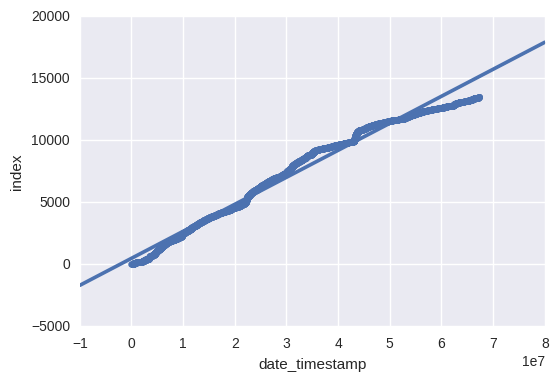

In [44]:
sns.regplot(x='date_timestamp', y='index', data=df)

В предыдущей работе мы уже заметили, что в работе сервиса был период нестабильности, и если взять только периоды стабильной работы - линейная регрессия дает куда более точное совпадение.

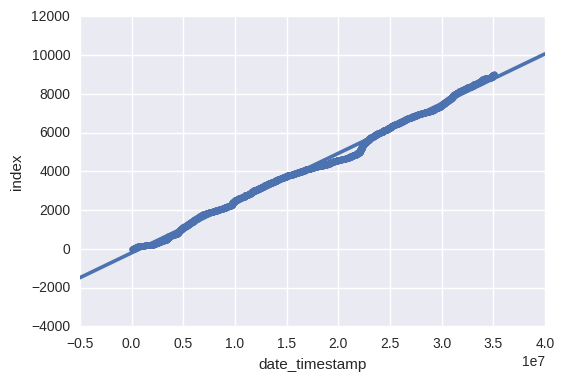

In [45]:
sns.regplot(x='date_timestamp', y='index', data=df[:9000])

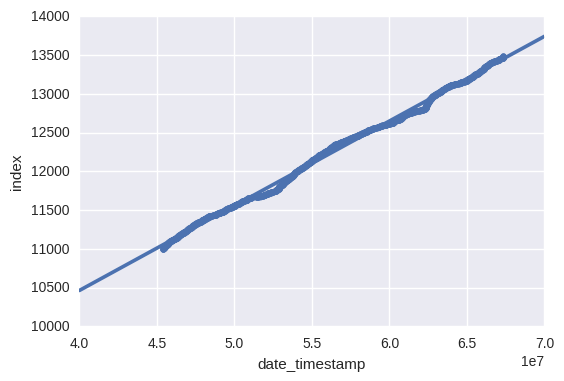

In [46]:
sns.regplot(x='date_timestamp', y='index', data=df[11000:])

К сожалению, seaborn не позволяет извлечь параметры, с которыми он построил регрессию, мотивируя это тем, что этот функционал исключительно для презентационных целей, но мы можем повторить то же самое с помощью statsmodel.

In [47]:
import statsmodels.api as sm
model = sm.RLM(df.index, df.date_timestamp, M=sm.robust.norms.LeastSquares())
results = model.fit()
results.params

date_timestamp    0.00023
dtype: float64

In [48]:
model = sm.RLM(df[:9000].index, df[:9000].date_timestamp, M=sm.robust.norms.LeastSquares())
results = model.fit()
results.params

date_timestamp    0.000248
dtype: float64

In [49]:
model = sm.RLM(df[11000:].index, df[11000:].date_timestamp, M=sm.robust.norms.LeastSquares())
results = model.fit()
results.params

date_timestamp    0.000216
dtype: float64

Таким образом мы смогли показать, что для равномерных данных наша примерная оценка частоты из первой домашней работы близка к оценке полученной с помощью регрессии, а также подтвердить сделанные визуально выводы о падении частоты обновлений после периода нестабильности. 